In [1]:
%matplotlib inline
import pdb, sys, os
sys.path.insert(0, './core/')
from minilib import CNN_AE_Wrapper, CNN_AE

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [10, 5]

from functools import partial
from collections import defaultdict

np.set_printoptions(suppress=True, linewidth=120, precision=4)
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 1000)

In [2]:
# mnist data processing block
ENDIAN = 'big'
MAX_VAL = 255.0
MNIST_IMG_SIZE = (28,28)

def read_images(fname, down_sample):
    f = open(fname,'rb')
    assert( int.from_bytes(f.read(4),ENDIAN) == 2051 )
    N = int.from_bytes(f.read(4),ENDIAN)
    row_size = int.from_bytes(f.read(4),ENDIAN)
    col_size = int.from_bytes(f.read(4),ENDIAN)
    buf = f.read(N*row_size*col_size)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32).reshape(N, row_size * col_size)
    f.close()

    # flatten the image and downsample a little bit, normalize to 0-1
    ret = []
    for row in data:
        img = row.reshape(row_size,col_size)

        if down_sample:
            img = block_reduce(img, (2,2), np.max)

        ret.append(img.flatten()/MAX_VAL)
    return np.array(ret)

def read_label(fname):
    f = open(fname,'rb')
    assert( int.from_bytes(f.read(4),ENDIAN) == 2049 )
    N = int.from_bytes(f.read(4),ENDIAN)
    buf = f.read(N)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    f.close()
    return data

mnist_dir = './data/digits/mnist/'
train_image = f'{mnist_dir}/train-images.idx3-ubyte'
train_label = f'{mnist_dir}/train-labels.idx1-ubyte'
test_image = f'{mnist_dir}/t10k-images.idx3-ubyte'
test_label = f'{mnist_dir}/t10k-labels.idx1-ubyte'


Xtr = read_images(train_image, False)
ytr = read_label(train_label)
Xte = read_images(test_image, False)
yte = read_label(test_label)

# stack all mnist data for training auto encoder
train_data = np.vstack([Xtr, 1-Xtr])
# train_data = Xtr
np.random.shuffle(train_data)


In [3]:
# check the load of mnist is correct 
print(train_data.shape)
# random visualize some samples 

VIS_ROWS = 4
VIS_COLS = 8
plt.rcParams['figure.figsize'] = [20, 10]

def visualize_images(img_array, selected, process = lambda x:x.reshape(*MNIST_IMG_SIZE)):
    k = 1
    fid = plt.figure()
    for i in range(VIS_ROWS):
        for j in range(VIS_COLS):
            plt.subplot(VIS_ROWS,VIS_COLS,k)
            plt.imshow(process(img_array[selected[k-1]]), cmap='gray' )
            k += 1

    plt.show()

# selected = np.random.choice(train_data.shape[0], VIS_ROWS*VIS_COLS, replace = False)
# visualize_images(train_data, selected)

(120000, 784)


In [15]:
from utmLib import utils
SAVE_PATH = 'output/cnn_auto_encoder.pkl'

if 0 and os.path.exists(SAVE_PATH):
    ae = utils.pkload(SAVE_PATH)
else:
    ae = CNN_AE_Wrapper(maxlr = 4e-2, wd = 0, batchsize = 1024, epoches = 120).fit(train_data)
    utils.pkdump(ae, SAVE_PATH)

Epoch:120 loss:1.2214870052412152


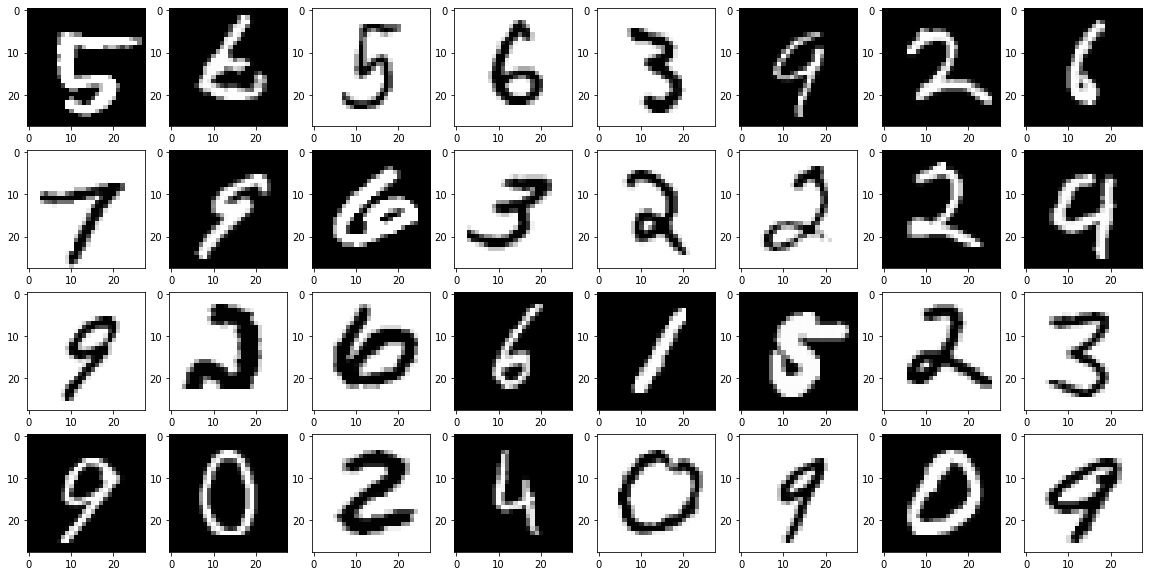

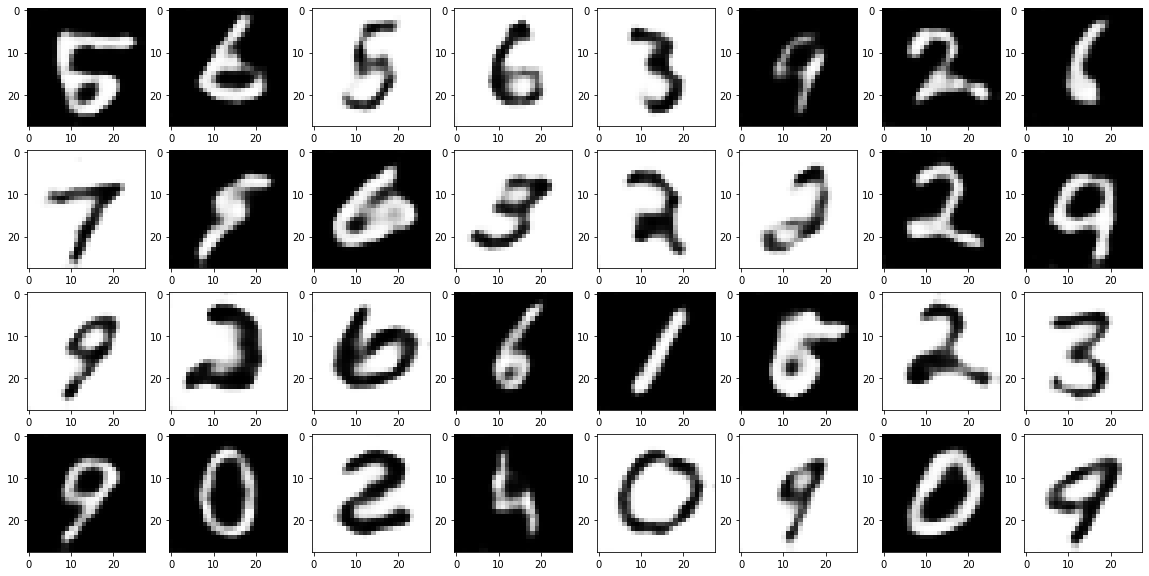

In [16]:
# test the quality of trained auto-encoder 
def test_projection(model, img_array):
    selected = np.random.choice(img_array.shape[0], VIS_ROWS*VIS_COLS, replace = False)
    visualize_images(img_array, selected)
    imgs = img_array[selected]
    F = model.transform(imgs)
    img_re = model.inverse_transform(F)
    visualize_images(img_re, np.arange(len(selected)) )

test_projection(ae, train_data)